# Permeability upscaling
In this tutorial we investigate a simple example of how PorePy may be used for numerical homogenization or upscaling for heterogeneous permeability fields in a single-phase Darcy flow problem. Two cases will be considered: One where the permeability is aligned with the pressure gradient, and one where the two are orthogonal. <br>

Refer to the tutorial "Get started" for definitions of geometrical entities, variables and data. As in that example, we choose a unit square domain. We set Dirichlet conditions on the bottom boundary and Neumann conditions on the lateral ones: $\Omega = [0, 1]^2$, $\partial \Omega_d = \partial \Omega|_{y=0}$, $\partial \Omega_n = \partial \Omega\setminus\partial \Omega_d$. The data are $f = 0$, $p_b = 0$ and $u_b = 1$ for $y = 1$ and $u_b = 0$ elsewhere. The permeability $K$ will be defined below. <br>
As usual, we start by importing the required modules:

In [6]:
import numpy as np
import scipy.sparse as sps
import porepy as pp

## Grid creation
We proceed by setting up a cartesian grid:

In [7]:
Nx = Ny = 12                      
g = pp.CartGrid([Nx, Ny], physdims=[1, 1])
g.compute_geometry()

In PorePy, tags indicating grid related quantities may be added directly to the dictionary stored as the grid field tags. We will use this to identify cells for subsequent permeability assignment:

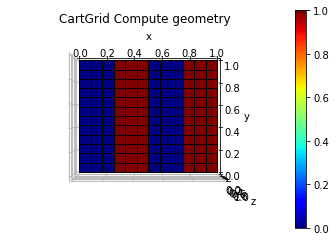

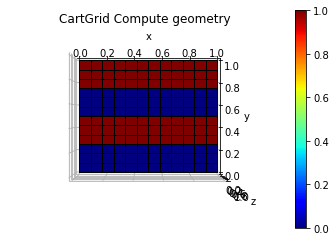

In [16]:
g.tags['vertical_stripes'] = np.logical_and(g.cell_centers[0] > .25,
                                            g.cell_centers[0] < .50) \
                             + g.cell_centers[0] > .75
g.tags['horizontal_stripes'] = np.logical_and(g.cell_centers[1] > .25,
                                              g.cell_centers[1] < .50) \
                               + g.cell_centers[1] > .75
g.tags['top_cells'] = g.cell_centers[1] > .50
mid_faces = np.isclose(g.face_centers[1], .5)

pp.plot_grid(g, g.tags['vertical_stripes'])
pp.plot_grid(g, g.tags['horizontal_stripes'])

## Problem data
We now construct the boundary condition object and two different permeability tensors, and assign parameters. Once again, we refer to "Get started" for more detailed explanations.

In [17]:
# Permeability
k_high = 1e3
k_low = 1
k_vertical = k_high * np.ones(g.num_cells)
k_horizontal = k_high * np.ones(g.num_cells)
k_vertical[g.tags['vertical_stripes']] = k_low

k_horizontal[g.tags['horizontal_stripes']] = k_low
perm_vertical = pp.SecondOrderTensor(g.dim, k_vertical)
perm_horizontal = pp.SecondOrderTensor(g.dim, k_horizontal)

# Boundary conditions
b_faces = g.tags['domain_boundary_faces'].nonzero()[0]

labels = np.array(['neu']*b_faces.size)
top_and_bottom = np.logical_or(g.face_centers[1, b_faces] == 0,
                               g.face_centers[1, b_faces] == 1)
labels[top_and_bottom] = 'dir'

bc = pp.BoundaryCondition(g, b_faces, labels)

bc_val = np.zeros(g.num_faces)
top = b_faces[g.face_centers[1, b_faces] == 1]
bc_val[top] = 1

# Parameters
param_vertical = pp.Parameters(g)
param_vertical.set_tensor("flow", perm_vertical)
param_vertical.set_bc("flow", bc)
param_vertical.set_bc_val("flow", bc_val)
data_vertical = {'param': param_vertical}
param_horizontal = pp.Parameters(g)
param_horizontal.set_tensor("flow", perm_horizontal)
param_horizontal.set_bc("flow", bc)
param_horizontal.set_bc_val("flow", bc_val)
data_horizontal = {'param': param_horizontal}

## Discretization and solution
We now discretize and solve the two problems using the two-point flux approximation:

In [18]:
discretizer = pp.Tpfa("flow")
A, b = discretizer.matrix_rhs(g, data_vertical)
p_vertical = sps.linalg.spsolve(A, b)

A, b = discretizer.matrix_rhs(g, data_horizontal)
p_horizontal = sps.linalg.spsolve(A, b)

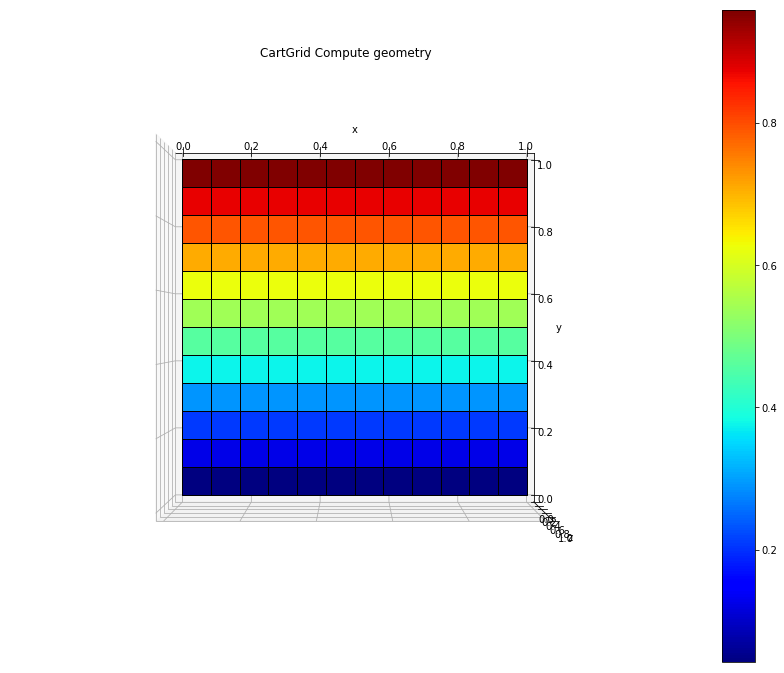

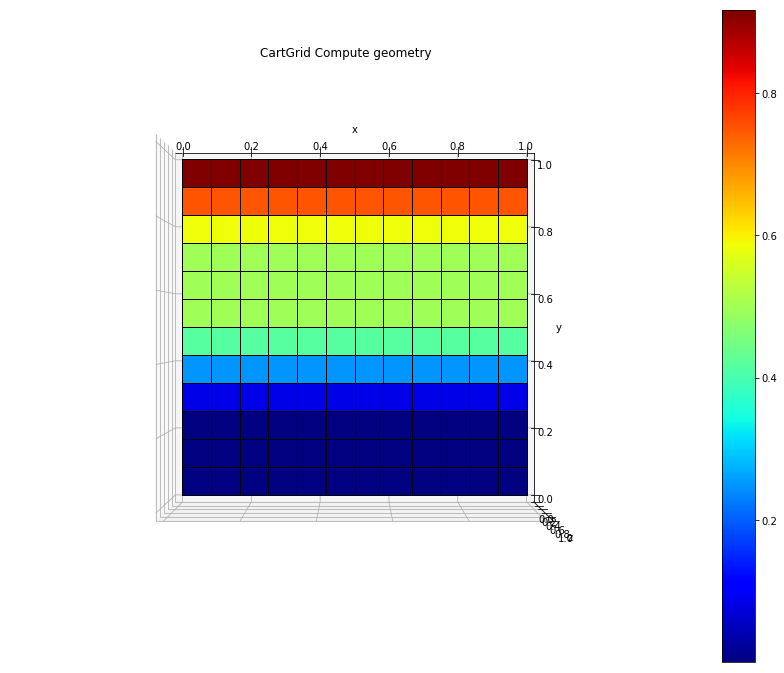

In [19]:
pp.plot_grid(g, p_vertical, figsize=(15, 12))
pp.plot_grid(g, p_horizontal, figsize=(15, 12))

We extract the fluxes over a horizontal line cutting through the domain, making sure that all fluxes have the same (downward) orientation.

In [20]:
sign_downwards = 1 - 2 * (g.face_normals[1, mid_faces] > 0)
fluxes_vertical = (data_vertical['flux'] * p_vertical)[mid_faces] * sign_downwards
fluxes_horizontal = (data_horizontal['flux'] * p_horizontal)[mid_faces] * sign_downwards

print("Total flux for ")
print("Vertical permeability pattern: ", np.sum(fluxes_vertical))
print("Horizontal permeability pattern: ", np.sum(fluxes_horizontal))

Total flux for 
Vertical permeability pattern:  500.5
Horizontal permeability pattern:  1.998001998


In [21]:
assert np.isclose(np.sum(fluxes_vertical), (k_high + k_low)/2)
assert np.isclose(np.sum(fluxes_horizontal), 2 * k_high * k_low / (k_high + k_low))